In [91]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


<br>

# **Understanding the Cox Proportional Hazards Model**

<dd>

The Cox Proportional Hazards Model is a widely used method in survival analysis to assess the effect of predictor variables on survival time. It is particularly valuable because it does not require specifying the underlying distribution of survival times, making it a semi-parametric model.

<dt>

<br>

---

<br>

### **Key Concepts**

**1. Hazard Function in the Cox Model**

<dd>

The hazard function, denoted as $h(t)$, represents the instantaneous risk of an event occurring at time $t$, given survival up to that time. The Cox model assumes that this hazard function can be expressed as:

$$
h(t | X) = h_0(t) e^{(\beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p)}
$$

where:


*   $h_0(t)$ is the baseline hazard function, representing the risk when all predictor variables are zero.
*   $X_1, X_2, ..., X_p$ are the predictor variables (covariates).
*   $\beta_1, \beta_2, ..., \beta_p$ are the coefficients that measure the impact of each predictor on survival.


This formulation allows us to analyze the effect of covariates on survival without making assumptions about the baseline hazard $h_0(t)$.

<dt>

**2. Proportional Hazards Assumption**

<dd>

The term proportional hazards comes from the assumption that the hazard ratios between individuals remain constant over time. That is, the effect of a covariate does not change as time progresses. Mathematically, for two individuals with predictor values $x_A$ and $x_B$:

$$
\frac{h(t | X = xA)}{h(t | X = xB)} = e^{(\beta_1 (x_{A1} - x_{B1}) + ... + \beta_p (x_{Ap} - x_{Bp}))}
$$

Since $h_0(t)$ cancels out, the hazard ratio is independent of time $t$.

If this assumption does not hold, alternative models like time-dependent covariates or stratified Cox models may be necessary.

<dt>

<br>

---

<br>

### **Interpreting the Cox Model**

**1. Hazard Ratio ($\mathrm{HR}$)**

<dd>

The hazard ratio (HR) quantifies the effect of a predictor variable on survival. It is calculated as:

$$
\mathrm{HR} = e^{\beta}
$$

where:


*   If $\mathrm{HR} > 1$, the predictor increases the hazard (higher risk, shorter survival time).

*   If $\mathrm{HR} < 1$, the predictor decreases the hazard (lower risk, longer survival time).

*   If $\mathrm{HR} = 1$, the predictor has no effect on survival.


<dt>

**2. Confidence Intervals ($\mathrm{CI}$)**

<dd>

To assess statistical significance, we compute the 95% confidence interval (CI) for the hazard ratio:

$$
\mathrm{CI} = \left[ e^{(\beta - 1.96 \cdot  σ)}, e^{(\beta + 1.96 \cdot  σ)} \right]
$$

where ${σ}$ is the standard error of the coefficient.

*   If the $\mathrm{CI}$ excludes 1, the result suggests a statistically significant association between the predictor and the hazard.
*   If the $\mathrm{CI}$ includes 1, the data do not provide strong enough evidence to conclude that an association between the predictor and the hazard exists.


<dt>

**3. p-value**

<dd>

The p-value tests whether the predictor has a significant effect on survival:

*   If p < 0.05, the variable is statistically significant.
*   If p > 0.05, there is no strong evidence that the predictor affects survival.

<dt>

<br>

---

<br>

### **Advantages**


*   No assumption on survival time distribution: Unlike parametric models, the Cox model does not require specifying the shape of the survival curve.

*   Handles censored data well: It efficiently includes individuals for whom the event has not yet occurred.

*   Interpretable coefficients: The exponentiated coefficients provide direct insights into risk factors.

<br>

---

<br>


### **Limitations**

*   Time-dependent covariates: While the basic Cox model assumes time-independent covariates, it can be extended to handle time-dependent covariates using appropriate data structures and modeling techniques.

*   Baseline hazard is not estimated: The model focuses on relative risks rather than predicting absolute survival probabilities.

<br>

---




# **Implementing the Cox Proportional Hazards Model**

<dd>

##Library import

To implement the Cox Proportional Hazards model in Python, we’ll primarily use the <code>lifelines</code> library — a specialized package for survival analysis. It provides easy-to-use tools for fitting and interpreting models like Kaplan-Meier, Cox Proportional Hazards, and more.

You can learn more about it in the official documentation:
https://lifelines.readthedocs.io

<dt>


In [92]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter

<dd>

The <code>lifelines</code> library might not be available by default, so if needed, you can install it using:

<dt>

In [2]:
!pip install lifelines --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.8 MB/s eta 0:00:00


---


# **Full Code**

<dd>

The function below fits a Cox Proportional Hazards model using the <code>lifelines</code> package.

**Inputs**

To successfully run your analysis, make sure your dataset meets the following requirements:

<ul>
  <li><b>df</b>: A pandas DataFrame containing your data.</li>

  <li><b>duration_col</b>: A numeric column indicating the time-to-event or follow-up time. Missing or non-numeric values will be removed.</li>

  <li><b>event_col</b>: A binary column (0 = censored, 1 = event occurred). Must also be numeric. Non-binary or missing values will be dropped.</li>

  <li><b>predictors</b>: A list of column names to include as predictors. These can be numeric or categorical (strings or pandas <code>category</code> type). Categorical variables will be automatically one-hot encoded (excluding the first category).</li>

  <li><b>labels</b> (optional): A dictionary to map column names or dummy variable names to human-readable labels. Helpful for improving the readability of the final output.</li>
</ul>

Important: Any row with missing data in <code>duration_col</code>, <code>event_col</code>, or any of the predictors will be removed before fitting the model.

**Outputs**
<dd>

The output consists of a pandas DataFrame with the following columns for each predictor:

<ul>
  <li><b>HR</b>: Hazard Ratio.</li>
  <li><b>CI_lower</b>: Lower bound of the 95% confidence interval.</li>
  <li><b>CI_upper</b>: Upper bound of the 95% confidence interval.</li>
  <li><b>p-value</b>: P-value for statistical significance. </li>
</ul>

<dt>

In [93]:
def execute_cox_model(df, duration_col, event_col, predictors, labels=None):

    # Ensure categorical variables are treated appropriately
    categorical_vars = df.select_dtypes(include=['object', 'category']).columns.intersection(predictors)
    for var in categorical_vars:
        df[var] = df[var].astype('category')

    # Convert categorical variables to dummies
    df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

    # Ensure numerical variables have the correct type
    df[duration_col] = pd.to_numeric(df[duration_col], errors='coerce')
    df[event_col] = pd.to_numeric(df[event_col], errors='coerce')

    # Update predictors to include one-hot encoded columns
    predictors = [c for c in df.columns if c in predictors or any(c.startswith(p + '_') for p in categorical_vars)]

    # Remove rows with missing values in essential columns
    df = df.dropna(subset=[duration_col, event_col] + predictors)

    # Select relevant columns
    df_cox = df[[duration_col, event_col] + predictors]

    # Fit the Cox model
    cph = CoxPHFitter()
    cph.fit(df_cox, duration_col=duration_col, event_col=event_col)

    # Model summary
    summary = cph.summary
    summary['HR'] = np.exp(summary['coef'])
    summary['CI_lower'] = np.exp(summary['coef'] - 1.96 * summary['se(coef)'])
    summary['CI_upper'] = np.exp(summary['coef'] + 1.96 * summary['se(coef)'])
    summary['p_adj'] = summary['p'].apply(lambda p: "<0.001" if p < 0.001 else round(p, 3))

    # Select relevant columns for the final summary
    summary_df = summary[['HR', 'CI_lower', 'CI_upper', 'p_adj']].reset_index()
    summary_df.rename(columns={'index': 'Variable', 'p_adj': 'p-value'}, inplace=True)

    # Replace variable labels if provided
    if labels:
        summary_df['Variable'] = summary_df['Variable'].map(labels).fillna(summary_df['Variable'])

    return summary_df, cph, df_cox

<br>

---

# **User Case 1**


### **1. Uploading and Loading the Dataset**


In [94]:
from google.colab import files
# Upload file
uploaded = files.upload()
df_model = pd.read_csv('df_model.csv')

Saving df_model.csv to df_model (1).csv




---

### **2. Running the cox model**

*   Defining Time, Event, and Predictor Variables
*   Running the Cox Model
*   Visualize the Model Results




In [95]:
# Time, outcome, and predictor variables
duration_col = 'HospitalLengthStay_trunc'  # Time variable
event_col = 'HospitalDischargeCode_trunc_bin'  # Binary outcome variable
cox_predictors = [
    'period', 'Idade_Agrupada2', 'ChronicHealthStatusName', 'obesity',
    'IsImmunossupression', 'IsSteroidsUse', 'IsSevereCopd', 'IsChfNyha',
    'cancer', 'ResourceIsRenalReplacementTherapy', 'ResourceIsVasopressors',
    'Vent_Resource'
]

# Run the Cox model
results, cph, df_cox = execute_cox_model(df_model, duration_col, event_col, cox_predictors)

# Display the results
print(results)

                                            covariate        HR  CI_lower  \
0                                    period_2022-2023  1.053884  0.968827   
1                                 Idade_Agrupada2_<65  0.777876  0.679785   
2                                Idade_Agrupada2_>=80  1.570852  1.421130   
3   ChronicHealthStatusName_Major assistance / bed...  1.368248  1.228323   
4            ChronicHealthStatusName_Minor assistance  1.188733  1.070908   
5                                         obesity_yes  0.820770  0.653215   
6                             IsImmunossupression_yes  1.238394  1.057788   
7                                   IsSteroidsUse_yes  1.083819  0.825148   
8                                    IsSevereCopd_yes  0.959102  0.860470   
9                                       IsChfNyha_yes  1.209235  1.072670   
10                                         cancer_yes  1.466217  1.315612   
11              ResourceIsRenalReplacementTherapy_yes  1.130405  1.011259   



---


### **3.Interpreting the Model Results**

*   Age Group (>=80): HR = 1.57, CI = [1.42, 1.73], p < 0.001 → Older patients have a higher risk.

*   Chronic Health Status (Major assistance): HR = 1.37, p < 0.001 → Patients with major assistance needs have increased risk.
*   Cancer: HR = 1.47, CI = [1.32, 1.63], p < 0.001 → Cancer increases risk significantly.
*   Vasopressor Use: HR = 1.52, p < 0.001 → Patients needing vasopressors have a higher risk.
*   Ventilation (NIV): HR = 0.41, CI = [0.36, 0.46], p < 0.001 → Non-invasive ventilation significantly reduces risk.











---

### **4. Analyzing results with Forest Plot**

<dd>

Forest Plot is a graphical method of analyzing the result table of the Cox model. Where each point is a Hazard Ratio and is visible the Lower and Upper confidence interval.

* Below is the full code for the Forest Plot.

<dt>

In [96]:
import pandas as pd
import plotly.graph_objs as go


def fig_forest_plot(
        df, dictionary=None,
        title='Forest Plot',
        labels=['Study', 'Hazard Ratio', 'LowerCI', 'UpperCI'],
        graph_id='forest-plot', graph_label='', graph_about='',
        only_display=False):

    # Ordering Values -> Descending Order
    df = df.sort_values(by=labels[1], ascending=True)

    # Error Handling
    if not set(labels).issubset(df.columns):
        print(df.columns)
        error_str = f'Dataframe must contain the following columns: {labels}'
        raise ValueError(error_str)

    # Prepare Data Traces
    traces = []

    # Add the point estimates as scatter plot points
    traces.append(
        go.Scatter(
            x=df[labels[1]],
            y=df[labels[0]],
            mode='markers',
            name='Hazard Ratio',
            marker=dict(color='blue', size=10))
    )

    # Add the confidence intervals as lines
    for index, row in df.iterrows():
        traces.append(
            go.Scatter(
                x=[row[labels[2]], row[labels[3]]],
                y=[row[labels[0]], row[labels[0]]],
                mode='lines',
                showlegend=False,
                line=dict(color='blue', width=2))
        )

    # Define layout
    layout = go.Layout(
        title=title,
        xaxis=dict(title='Hazard Ratio'),
        yaxis=dict(
            title='', automargin=True, tickmode='array',
            tickvals=df[labels[0]].tolist(), ticktext=df[labels[0]].tolist()),
        shapes=[
            dict(
                type='line', x0=1, y0=-0.5, x1=1, y1=len(df[labels[0]])-0.5,
                line=dict(color='red', width=2)
            )],  # Line of no effect
        margin=dict(l=100, r=100, t=100, b=50),
        height=600
    )

    return go.Figure(data=traces, layout=layout)

<dd>

* Executing Forest Plot function:

<dt>

In [98]:
graph = fig_forest_plot(
    df = results,
    labels = results.columns.tolist(),
    only_display=True
)

graph.show()

---

## **User Case 2**


### **1. Uploading and Loading the Dataset**

In [ ]:
from google.colab import files
# Upload file
uploaded = files.upload()
df_map = pd.read_csv('df_map.csv')

Saving df_map.csv to df_map.csv


---
### **2. Preprocessing the Dataset to Ensure Binary Outcome**

<dd>

Since the outcome must be binary, this treatment should be applied before executing the code.

<dt>

In [ ]:
df_map["outco_binary_outcome"] = df_map["outco_binary_outcome"].map({
    "Death": 1,
    "Censored": 0,
    "Discharged": 0
})



---

### **3. Running the cox model**

*   Defining Time, Event, and Predictor Variables
*   Running the Cox Model
*   Visualize the Model Results



In [ ]:
# Time, outcome, and predictor variables
duration_col = 'drug14_antiviralday'  # Time variable
event_col = 'outco_binary_outcome'  # Binary outcome variable
cox_predictors = [
    'demog_sex', 'demog_race___Latin American', 'expo14_setting', 'comor_aids_art',
    'comor_chrkidney', 'comor_chrpulmona', 'comor_liverdisease', 'comor_chrcardiac',
    'adsym_mobile', 'vital_o2supp_type'
]

# Run the Cox model
results = execute_cox_model(df_map, duration_col, event_col, cox_predictors)

# Display the results
print(results)

ValueError: could not convert string to float: 'udkfvdxzap'



---

### **4. Executing Forest Plot**


In [ ]:
graph = fig_forest_plot(
    df = results,
    labels = results.columns.tolist(),
    only_display=True
)

graph.show()

---

<br>

### **Assumptions of the Cox Proportional Hazards Model**

<dd>

The Cox model relies on several critical assumptions that must hold for its estimates to be valid and interpretable. These assumptions relate to the nature of covariate effects, data structure, and censoring mechanisms.

<br>

* **Proportional Hazards Assumption**: This is the primary structural assumption of the Cox model. It states that the hazard ratios between individuals are constant over time. That is, the effect of a covariate is multiplicative with respect to the baseline hazard and does not vary during follow-up.
  * **Implications**: Enables a time-invariant interpretation of covariate effects as hazard ratios.
  * **If Violated**: Incorporate time-dependent covariate interactions or use stratified Cox models.
  * **Evaluation**: Checked using Schoenfeld residuals or log(-log(survival)) vs. log(time) plots. Temporal trends indicate violations.

<br>

* **Linearity on the Log-Hazard Scale**: The model assumes a linear relationship between continuous covariates and the logarithm of the hazard function. This does not apply to categorical variables, which are handled through dummy encoding.
  * **Implications**: Non-linearity may lead to biased effect estimates and reduced model fit.
  * **If Violated**: Use polynomial terms or splines (e.g., restricted cubic splines) to better model the functional form.
  * **Evaluation**: Martingale residuals plotted against covariates can reveal non-linear patterns.

<br>

* **Independence of Observations**: Survival times across individuals must be independent. This assumption may be violated in clustered or repeated-measures designs.
  * **Implications**: Ignoring dependence leads to underestimated standard errors and invalid inferences.
  * **If Violated**: Use frailty models or apply robust (clustered) standard errors.
  * **Evaluation**: Not directly testable; however, study design review and examining residual structure across groups (e.g., hospitals) may reveal dependence.

<br>

* **Non-Informative Censoring**: The probability of being censored must be independent of the underlying event risk, conditional on covariates.
  * **Implications**: Informative censoring can bias hazard ratios and survival estimates.
  * **If Violated**: Consider joint models or alternative frameworks that explicitly model the censoring process.
  * **Evaluation**: This cannot be formally tested with survival data alone. Assess whether censored individuals differ systematically from those with observed events (e.g., via descriptive statistics or survival curves stratified by censoring groups).

<dt>

<br>

---

<br>

### **Best Practices for Model Building**

<dd>

In addition to satisfying assumptions, the quality of a Cox model depends heavily on thoughtful construction. The following practices help ensure the model is both robust and interpretable.

<br>

* **Feature Selection**: Selecting appropriate covariates is a balancing act. Including irrelevant predictors increases model variance, while excluding important ones introduces bias. The best models combine prior scientific knowledge with algorithmic selection techniques to isolate meaningful predictors. It's also important to guard against overfitting, especially in small datasets. Using penalized regression or validating the model on external data can help ensure generalizability.
  * **LASSO**: A regularization method that penalizes the absolute value of coefficients, shrinking some to zero and thus performing automatic variable selection. It's especially powerful in high-dimensional data settings.
  * **COSSO**: A flexible method that extends traditional variable selection to allow for non-linear relationships using smooth components. It's particularly useful when the true functional form of covariates is unknown.
  * **Information Criteria**: AIC and BIC are widely used to compare models, favoring those that balance goodness-of-fit with parsimony.
  * **Best Practice**: Rather than rely on univariate screening or arbitrary cutoffs, variable selection should incorporate both statistical evidence and contextual relevance.

<br>

* **Assessment of Multicollinearity**: Multicollinearity refers to strong correlations between covariates, which can obscure individual effects and destabilize estimates. When predictors share overlapping information, the model may produce inflated standard errors and erratic coefficient estimates. In some cases, multicollinearity does not affect prediction but does impair interpretation. When this occurs, focus should shift from individual coefficients to overall model performance.
  * **Detection**: Tools such as correlation matrices or Variance Inflation Factors (VIF) help identify problematic collinearity.
  * **Solutions**: The issue can often be addressed by removing one of the correlated variables, combining them into an index, or using ridge regression, which imposes a penalty on the size of coefficients and helps stabilize the estimation.

<br>

* **Adequate Sample Size**: Cox models rely on the number of events—rather than total sample size—for statistical power. A model with too many predictors and too few events can result in unstable estimates and misleading conclusions.
  * **Guideline**: While the conventional rule suggests 10–20 events per covariate, recent research shows that 5–9 EPV may be acceptable in models using regularization. For models with time-varying covariates or interactions, higher EPV is advisable. This ensures the model can reasonably estimate parameters without overfitting.
  * **Practical Consideration**: It’s not enough to have a large dataset; what matters is the number of observed (non-censored) events. This distinction is especially important in studies with high censoring rates.

<dt>

<br>

---

<br>

### **Model Validation**

Validation assesses the reliability and generalizability of the Cox model by examining how well it fits the data, discriminates between individuals, and produces calibrated predictions.

<br>

**1. Goodness-of-Fit**

Assesses whether the model's structure adequately describes the observed data.

* **Schoenfeld Residuals**

  <dd>

  These residuals assess whether a covariate’s effect remains constant throughout the follow-up period. A correlation between a variable's Schoenfeld residuals and time suggests that its effect is time-varying, which violates the **proportional hazards (PH) assumption**. The analysis involves both a statistical test and a visual inspection of residual plots.

  * **Interpreting the Output Table**

    The statistical test, generated by `check_assumptions()`, provides a formal test for the PH assumption for each covariate.
    * **Null Hypothesis**: The effect of the covariate is constant over time (i.e., the PH assumption holds).
    * **P-value (`p`)**:
      * **p > 0.05**: There is no statistical evidence to reject the null hypothesis. The assumption is considered to hold for the covariate.
      * **p < 0.05**: We reject the null hypothesis. This indicates a violation of the PH assumption, meaning the covariate's effect likely changes over time.

  * **Interpreting the Residual Plots**

    The residual plots provide a visual confirmation of the statistical test and are crucial for understanding the nature of any potential violation. The interpretation differs for continuous and categorical variables.

    * **For Continuous Covariates**:
      * A plot showing a random cloud of points scattered horizontally around the `y=0` line supports the PH assumption.
      * A plot showing a clear trend or pattern (e.g., a consistent upward or downward slope) suggests the effect is not constant, violating the assumption.

    * **For Categorical/Binary Covariates**:
      * The plot will display distinct, horizontal bands of points, with each band corresponding to a specific category (e.g., one band for 'True', another for 'False'). This is expected.
      * The PH assumption is supported if these bands are **flat and parallel** to the horizontal line at `y=0`. This indicates that the effect of each category, while different from each other, remains constant over time.
      * A violation would be indicated if any of the bands showed a clear slope over time.

  </dd>

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def test_and_plot_schoenfeld(cph_model, dataframe, duration_col, event_col, covariate_to_plot):
    """
    Runs the PH test, prints the results table, and manually plots Schoenfeld
    residuals for a single specified covariate.

    Args:
        cph_model (CoxPHFitter): The trained Cox Proportional Hazards model object.
        dataframe (pd.DataFrame): The DataFrame used to fit the model.
        duration_col (str): The name of the duration column.
        event_col (str): The name of the event column.
        covariate_to_plot (str): The name of the single covariate for which to plot residuals.
    """
    try:
        # Run the test and print the full results table
        print("--- Proportional Hazards Assumption Test Results (All Covariates) ---")
        # This call prints the statistical summary table to the console.
        cph_model.check_assumptions(dataframe, show_plots=False, p_value_threshold=0.05)

        # Manually calculate and plot residuals for the specified covariate
        print(f"\n--- Displaying Schoenfeld Residual Plot for: '{covariate_to_plot}' ---")

        E = dataframe[event_col].values
        T = dataframe[duration_col].values
        X_p = dataframe[covariate_to_plot].values
        risk_scores = cph_model.predict_partial_hazard(dataframe).values

        unique_event_times = np.unique(T[E == 1])

        residuals = []
        times = []

        for t in unique_event_times:
            at_risk_mask = T >= t
            events_at_t_mask = (T == t) & (E == 1)

            risk_set_scores = risk_scores[at_risk_mask]
            risk_set_X_p = X_p[at_risk_mask]

            weighted_avg_X_p = np.sum(risk_set_X_p * risk_set_scores) / np.sum(risk_set_scores)

            event_subjects_X_p = X_p[events_at_t_mask]

            for val in event_subjects_X_p:
                residuals.append(val - weighted_avg_X_p)
                times.append(t)

        # Plot the results
        residuals = np.array(residuals)
        times = np.array(times)

        lowess = sm.nonparametric.lowess

        plt.figure(figsize=(10, 6))
        plt.scatter(times, residuals, marker='.', alpha=0.5, label='Schoenfeld Residuals')

        plt.axhline(y=0, color='k', linestyle='--')
        plt.title(f'Schoenfeld Residuals for {covariate_to_plot}')
        plt.xlabel('Time')
        plt.ylabel(f'Residuals for {covariate_to_plot}')
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"An error occurred during Schoenfeld residual analysis: {e}")

--- Proportional Hazards Assumption Test Results (All Covariates) ---
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 10357 total observations, 8097 right-censored observations>
         test_name = proportional_hazard_test

---
                                                           test_statistic      p  -log2(p)
ChronicHealthStatusName_Major assistance / bedridden km              9.80 <0.005      9.16
                                                     rank           12.12 <0.005     10.97
ChronicHealthStatusName_Minor assistance             km              2.22   0.14      2.87
                                                     rank            2.74   0.10      3.35
Idade_Agrupada2_<65                                  km              0.00   0.94      0.08
                                                     rank            0.00   0.96      0.06
Idade_Agrupada2_>=80                                 km              0.14   0.71      0.50
                                                     rank            0.12   0.73      0.45
IsChfNyha_yes                                        km              0.00   0.96      0.05
                                                     rank            0.23   0.63      0.66
IsImmunossupression_yes                              km              0.60   0.44      1.19
                                                     rank            1.13   0.29      1.79
IsSevereCopd_yes                                     km              6.85   0.01      6.82
                                                     rank            5.66   0.02      5.85
IsSteroidsUse_yes                                    km              0.47   0.50      1.01
                                                     rank            0.55   0.46      1.12
ResourceIsRenalReplacementTherapy_yes                km             24.55 <0.005     20.40
                                                     rank           39.75 <0.005     31.69
ResourceIsVasopressors_yes                           km             33.45 <0.005     27.03
                                                     rank           38.51 <0.005     30.77
Vent_Resource_VNI                                    km             36.28 <0.005     29.13
                                                     rank           53.21 <0.005     41.60
cancer_yes                                           km              0.00   0.96      0.06
                                                     rank            0.00   0.97      0.05
obesity_yes                                          km              0.14   0.71      0.49
                                                     rank            0.56   0.45      1.14
period_2022-2023                                     km              1.27   0.26      1.95
                                                     rank            0.85   0.36      1.49



1. Variable 'ChronicHealthStatusName_Major assistance / bedridden' failed the non-proportional test: p-value is 0.0005.

   Advice: with so few unique values (only 2), you can include
`strata=['ChronicHealthStatusName_Major assistance / bedridden', ...]` in the call in `.fit`. See
documentation in link [E] below.

2. Variable 'IsSevereCopd_yes' failed the non-proportional test: p-value is 0.0089.

   Advice: with so few unique values (only 2), you can include `strata=['IsSevereCopd_yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

3. Variable 'ResourceIsRenalReplacementTherapy_yes' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include
`strata=['ResourceIsRenalReplacementTherapy_yes', ...]` in the call in `.fit`. See documentation in
link [E] below.

4. Variable 'ResourceIsVasopressors_yes' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can in

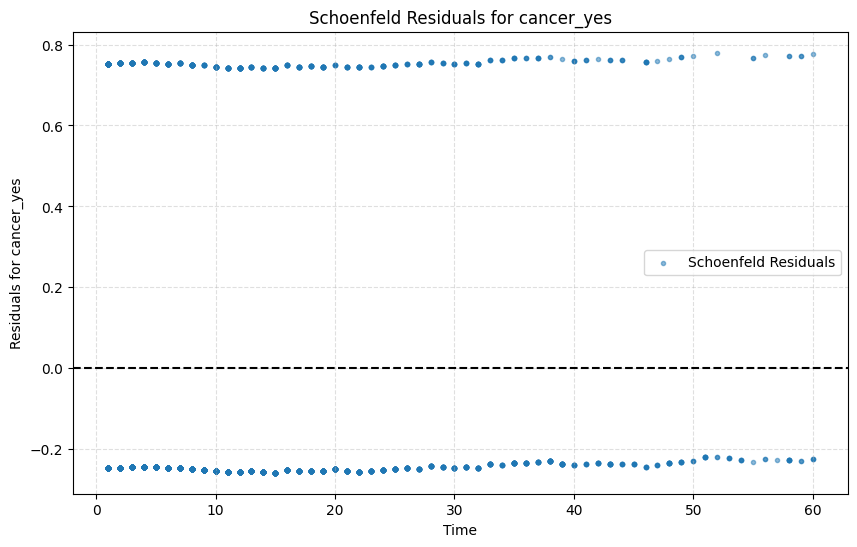

In [102]:
# Choose the variable you want to visualize
variable_to_plot = 'cancer_yes'

# Execute the function
test_and_plot_schoenfeld(
    cph,
    df_cox,
    duration_col,
    event_col,
    covariate_to_plot=variable_to_plot
)

---

<br>

* **Martingale Residuals**

  <dd>

  Martingale residuals are a diagnostic tool used to assess the functional form of covariates in a Cox proportional hazards model. They are primarily used to check the assumption that each covariate has a linear relationship with the log-hazard. A non-random pattern in the residuals can indicate that this assumption is violated.

  * **Interpretation for Continuous Variables**

    The standard approach is to create a scatter plot of the Martingale residuals against the values of the continuous covariate.
    * **Well-specified model**: The points should form a random "cloud" centered around the horizontal line at `y=0`. The smoothed trend line (like a LOESS curve) should be roughly flat and close to zero.
    * **Poorly-specified model**: A systematic pattern, such as a curve or a consistent slope in the smoothed trend line, suggests that the linearity assumption is violated. For example, a U-shaped pattern might indicate that both very low and very high values of the covariate increase the risk, suggesting a quadratic term (like x²) might be needed in the model.

  * **Interpretation for Categorical Variables**

    When dealing with categorical predictors, the scatter plot is not useful. Instead, we use box plots to compare the distribution of Martingale residuals across the different categories of a predictor.
    * **Well-specified model**: The box plots for each category (e.g., 'True' and 'False') should have their medians (the line inside the box) centered close to the zero reference line.
    * **Poorly-specified model**: If a box plot for a specific category is systematically shifted above or below zero, it suggests the model is not accurately capturing the effect of that category.
        * A median **above zero** suggests the model may be **underestimating the risk** for that group.
        * A median **below zero** suggests the model may be **overestimating the risk** for that group.

  * **Outlier Detection**

    Martingale residuals are also useful for identifying potential outliers. The residuals range from negative infinity to 1, specifically (−∞, 1).
    * Subjects with large **negative** residuals (e.g., -2, -3, or lower) are potential outliers. These are individuals who "should have" had an event according to their high-risk profile but survived much longer than expected.
    * Subjects with residuals close to **1** are those who had an event very early, despite having a low predicted risk.

  </dd>

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_martingale_residuals_manual(cph_model, dataframe, duration_col, event_col, covariate_name):
    """
    Manually calculates and plots Martingale residuals against a categorical covariate.
    This "from-first-principles" approach is robust across different lifelines versions.

    Args:
        cph_model (CoxPHFitter): The trained Cox Proportional Hazards model object.
        dataframe (pd.DataFrame): The DataFrame used to fit the model.
        duration_col (str): The name of the duration column.
        event_col (str): The name of the event column.
        covariate_name (str): The name of the categorical covariate to analyze.
    """
    try:
        # Get event status (delta_i in the formula)
        E = dataframe[event_col].values

        # Get predicted risk scores (exp(beta * X_i))
        risk_scores = cph_model.predict_partial_hazard(dataframe).values

        # Get the cumulative baseline hazard from the model
        baseline_hazard_df = cph_model.baseline_cumulative_hazard_

        # For each subject, we need to find the cumulative baseline hazard at their specific duration time.
        # We can use numpy's searchsorted for an efficient lookup.
        baseline_hazard_times = baseline_hazard_df.index.values
        baseline_hazard_values = baseline_hazard_df.iloc[:, 0].values

        # Find the insertion points for each subject's duration time in the baseline hazard times
        indices = np.searchsorted(baseline_hazard_times, dataframe[duration_col].values, side='right') - 1

        # Handle cases where the time is before the first baseline hazard time point
        indices = np.maximum(0, indices)

        # Get the corresponding cumulative hazard for each subject
        cumulative_hazard_at_T = baseline_hazard_values[indices]

        # Calculate the cumulative hazard for each subject: H_0(T_i) * exp(beta * X_i)
        cumulative_subject_hazard = cumulative_hazard_at_T * risk_scores

        # Finally, calculate the Martingale residual: delta_i - H_i(T_i)
        martingale_residuals = E - cumulative_subject_hazard

        # Prepare data for plotting
        plot_df = pd.DataFrame({
            'martingale_residuals': martingale_residuals,
            covariate_name: dataframe[covariate_name]
        })

        # Plot the results
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=covariate_name, y='martingale_residuals', data=plot_df)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title(f'Martingale Residuals by {covariate_name}')
        plt.xlabel(covariate_name)
        plt.ylabel('Martingale Residuals')
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.show()

    except Exception as e:
        print(f"An error occurred during residual plotting: {e}")

Generating Martingale residual plot for the variable: 'Vent_Resource_VNI'...


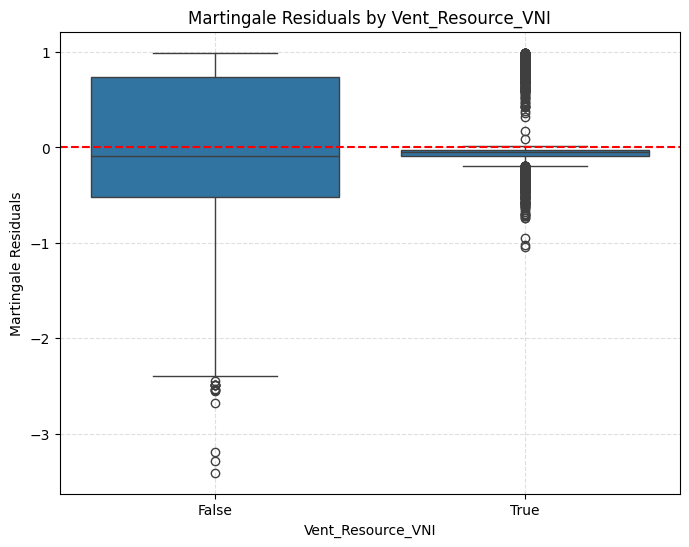

In [104]:
# Choose the categorical variable you want to inspect
variable_to_check = 'Vent_Resource_VNI'

print(f"Generating Martingale residual plot for the variable: '{variable_to_check}'...")

# Execute the function
plot_martingale_residuals_manual(
    cph,
    df_cox,
    duration_col,
    event_col,
    covariate_name=variable_to_check
)

---

<br>

**2. Discrimination**


Measures the model's ability to correctly distinguish between individuals who will experience an event and those who will not.

* **Concordance Index (C-Index)**

<dd>

Measures discriminative performance — the model’s ability to correctly rank individuals by risk. In survival analysis, it quantifies how well the predicted risk aligns with actual event times.

$$
C = \frac{\text{Number of concordant pairs}}{\text{Number of comparable pairs}}
$$

* **Range**: 0.5 (no discrimination) to 1.0 (perfect discrimination).
* **Interpretation**: A C-index of 0.75 means the model correctly ranked the event risk in 75% of comparable subject pairs.
* **Censoring-Aware**: Unlike the traditional AUC, the C-index handles right-censored data appropriately.
* **Use Case**: Especially useful to assess how well the model differentiates between high-risk and low-risk individuals — commonly used in model selection and validation steps.

<dt>

In [105]:
from lifelines.utils import concordance_index

def calculate_c_index(cph_model, dataframe, duration_col_name, event_col_name):
    """
    Calculates and prints the Concordance Index (C-Index) for a Cox model.

    Args:
        cph_model: The trained Cox Proportional Hazards model object.
        dataframe: The DataFrame used to fit the model.
        duration_col_name (str): The name of the duration column.
        event_col_name (str): The name of the event column.
    """
    # Predict partial hazard scores (risk ranking)
    predicted_scores = -cph_model.predict_partial_hazard(dataframe)

    # Compute C-index
    c_index = concordance_index(dataframe[duration_col_name], predicted_scores, dataframe[event_col_name])

    print(f"C-Index: {c_index:.3f}")

In [106]:
# Execute the function
calculate_c_index(cph, df_cox, duration_col, event_col)

C-Index: 0.752


---

<br>

* **Time-Dependent ROC and AUC**

  <dd>

  While the C-index gives a global measure of discrimination, a time-dependent Receiver Operating Characteristic (ROC) curve provides a snapshot of the model's performance at a **specific point in time (t)**. It evaluates the model's ability to correctly distinguish between subjects who experience an event by time t and those who survive past time t.

  * **Methodology**:
    To create the curve for a given `target_time`, subjects are classified as:
    * **Cases**: Those who experienced the event at or before `target_time`.
    * **Controls**: Those who remained event-free after `target_time`.
    Subjects censored before `target_time` are excluded from this specific analysis, as their status at that time is unknown. This turns the survival problem into a binary classification problem for that moment, allowing the use of standard ROC analysis.

  * **Interpreting the Plot and AUC**
    * **ROC Curve**: It plots the True Positive Rate (Sensitivity) against the False Positive Rate (1 - Specificity) at `target_time`. An ideal curve "hugs" the top-left corner, indicating high sensitivity and high specificity.
    * **AUC (Area Under the Curve)**: This value quantifies the curve's performance with a single number.
      * **Range**: 0.5 (no better than random chance) to 1.0 (perfect discrimination). An AUC > 0.7 is often considered acceptable.
      * **Interpretation**: An AUC of 0.8 at `t=30` means there is an 80% probability that the model will assign a higher risk score to a randomly chosen subject who has an event before day 30 than to a randomly chosen subject who survives past day 30.

  </dd>

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_auc_manual(cph_model, dataframe, duration_col, event_col, target_time):
    """
    Calculates and plots the time-dependent ROC curve and AUC for a specific time point.
    This robust version manually defines cases/controls and uses scikit-learn for the calculation.

    Args:
        cph_model (CoxPHFitter): The trained Cox Proportional Hazards model object.
        dataframe (pd.DataFrame): The DataFrame used to fit the model.
        duration_col (str): The name of the duration column.
        event_col (str): The name of the event column.
        target_time (int or float): The target time to evaluate the ROC/AUC.
    """
    try:
        # Get model risk scores
        risk_scores = cph_model.predict_partial_hazard(dataframe)

        # Define cases and controls for the specific target_time
        # Cases: Subjects who had an event at or before the target time.
        cases_mask = (dataframe[duration_col] <= target_time) & (dataframe[event_col] == 1)

        # Controls: Subjects who were still event-free after the target time.
        controls_mask = dataframe[duration_col] > target_time

        # We can only compare cases and controls. Exclude subjects censored before target_time.
        relevant_subjects_mask = cases_mask | controls_mask

        if not relevant_subjects_mask.any():
            print(f"Error: No subjects available for comparison at t={target_time}.")
            return

        # Prepare the data for scikit-learn
        y_true = cases_mask[relevant_subjects_mask]
        y_score = risk_scores[relevant_subjects_mask]

        # Calculate ROC curve and AUC using scikit-learn
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        auc_value = roc_auc_score(y_true, y_score)

        # Plot the results
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_value:.3f})')
        plt.fill_between(fpr, tpr, alpha=0.2)
        plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.5)')

        plt.title(f'Time-Dependent ROC Curve at t={target_time}')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.axis('square')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.show()

    except Exception as e:
        print(f"An error occurred during ROC/AUC plotting: {e}")

Generating ROC curve and AUC for t=59.9...


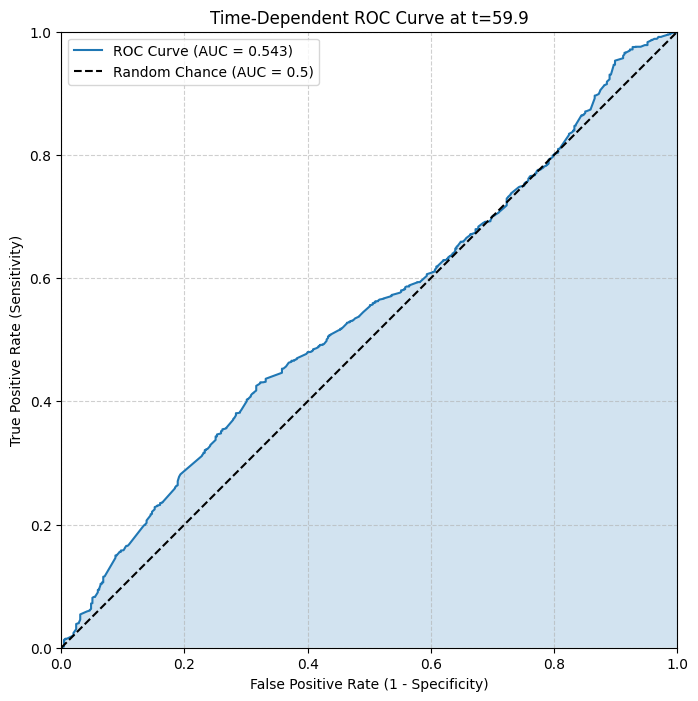

In [109]:
# Define the time point you want to evaluate
# For example, 5-year survival (if your time unit is years) or 365 days (if your time unit is days).
time_to_evaluate = 59.9 # <--- IMPORTANT: Adjust this time to a relevant value for your data

# Execute the function
print(f"Generating ROC curve and AUC for t={time_to_evaluate}...")

plot_roc_auc_manual(
    cph,
    df_cox,
    duration_col,
    event_col,
    target_time=time_to_evaluate
)

---

<br>

**3. Calibration**

Calibration evaluates how closely the predicted survival probabilities align with observed outcomes. For survival models, this assessment is performed **for a specific point in time (t)**.

* **Calibration Plots**: These plots compare predicted survival probabilities to observed survival rates across different risk strata. To construct the plot, subjects are typically grouped into quantiles (e.g., deciles) based on their predicted survival probability. For each group, the average predicted probability (X-axis) is plotted against the observed survival fraction (Y-axis), which is estimated using the Kaplan-Meier method. Ideally, the points should fall near the 45° diagonal line, indicating perfect calibration.

  * **Interpretation**:
    The position of the points relative to the diagonal line indicates if the model is optimistic or pessimistic.
    * Points **above** the diagonal (`Observed > Predicted`): Indicate the model was too **pessimistic**. The actual survival rate for that risk group was higher than what the model predicted.
    * Points **below** the diagonal (`Observed < Predicted`): Indicate the model was too **optimistic**. The actual survival rate was lower than what the model predicted.
    * Non-linear patterns may indicate the need for model recalibration.

* **Calibration Belt**: An advanced visual tool that overlays confidence bands around the calibration curve, allowing formal hypothesis testing to assess model miscalibration. **This method is not natively available in Python** but can be implemented in R using the `calibrationbelt package`. In Python, similar approximations can be created using confidence intervals derived from binomial theory.

Calibration is essential for evaluating not only model accuracy but also clinical trustworthiness in predicted probabilities.


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

def plot_calibration(cph_model, dataframe, duration_col_name, event_col_name, t):
    """
    Generates and displays a calibration plot for a Cox model at a specific time point.

    This function compares predicted survival probabilities with observed survival fractions
    by grouping subjects into deciles of predicted risk.

    Args:
        cph_model: The trained Cox Proportional Hazards model object.
        dataframe: The DataFrame used to fit the model.
        duration_col_name (str): The name of the duration column.
        event_col_name (str): The name of the event column.
        t (int or float): The specific time point at which to evaluate calibration.
    """
    # Predict survival probabilities at time t
    predicted_survival = cph_model.predict_survival_function(dataframe, times=[t]).squeeze()

    # Create a new DataFrame for calibration analysis
    calib_df = pd.DataFrame({
        'predicted_survival': predicted_survival,
        'duration': dataframe[duration_col_name],
        'event': dataframe[event_col_name]
    })

    # Group subjects into deciles based on predicted survival
    calib_df['decile'] = pd.qcut(calib_df['predicted_survival'], 10, labels=False, duplicates='drop')

    # Calculate mean predicted probability and observed survival for each decile
    observed_probs = []
    predicted_probs = []

    # Ensure deciles are sorted for a proper line plot
    for i in sorted(calib_df['decile'].unique()):
        decile_df = calib_df[calib_df['decile'] == i]

        mean_predicted = decile_df['predicted_survival'].mean()

        kmf = KaplanMeierFitter()
        kmf.fit(decile_df['duration'], event_observed=decile_df['event'])
        observed_survival = kmf.predict(t, interpolate=True)

        predicted_probs.append(mean_predicted)
        observed_probs.append(observed_survival)

    # Create the plot
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    ax.plot(predicted_probs, observed_probs, 'o-', ms=6, label='Model Calibration')

    ax.set_xlabel(f'Predicted Survival Probability at t={t}')
    ax.set_ylabel('Observed Survival Fraction (Kaplan-Meier)')
    ax.set_title('Calibration Plot')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.show()

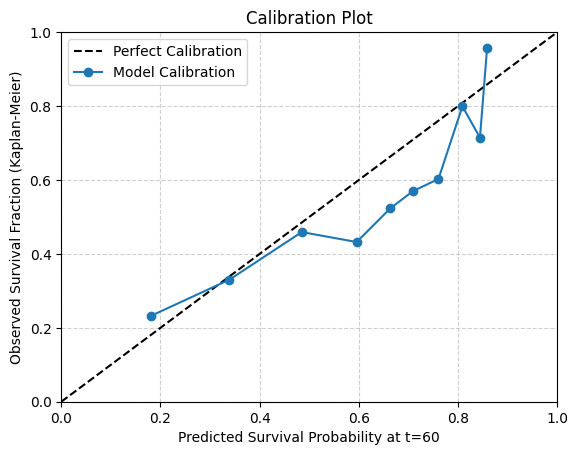

In [111]:
import warnings
from lifelines.exceptions import ApproximationWarning

# Choose a meaningful time point for calibration
calibration_time = 60 # <--- IMPORTANT: Adjust this time to a relevant value for your data

# Execute the function
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ApproximationWarning)
    plot_calibration(cph, df_cox, duration_col, event_col, t=calibration_time)

---

<br>

* **Time-Dependent Brier Score**

<dd>

  The Brier Score evaluates the accuracy of a model's probabilistic predictions. It measures the mean squared difference between the predicted survival probability at a specific time *t* and the subject's actual outcome at that time.

  * **Formula (Conceptual)**:
    For a simplified scenario without censoring, the formula is:
$$
BS(t) = \frac{1}{N} \sum_{i=1}^{N} \left( \hat{S}(t|x_i) - I(T_i > t) \right)^2
$$
Where $\hat{S}(t|x_i)$ is the predicted survival probability and $I(T_i > t)$ is the actual status (1 if survived past t, 0 otherwise).

  * **Censoring-Aware Implementation**:
    Since survival data often contains censored observations, a simple average is biased. The actual implementation must adjust for this using **Inverse Probability of Censoring Weighting (IPCW)**. This method weights each subject's contribution to the score by the estimated probability of them *not* being censored.

  * **Interpretation**:
    * Values range from 0 (perfect prediction) to a maximum (often near 0.25).
    * Lower values are better, indicating a smaller error between predictions and reality.
    * The score can be plotted over time to evaluate if the model's accuracy is stable across different time horizons.

</dd>

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

def evaluate_brier_score(cph_model, dataframe, duration_col, event_col, target_time, plot=True):
    """
    Calculates and optionally plots the time-dependent IPCW Brier score up to a target time.

    This function calculates the Brier score up to a user-defined target time,
    plots the results, and highlights the score at the target time.

    Args:
        cph_model (CoxPHFitter): The trained Cox Proportional Hazards model object.
        dataframe (pd.DataFrame): The DataFrame used to fit the model.
        duration_col (str): The name of the duration column.
        event_col (str): The name of the event column.
        target_time (int or float): The target time to evaluate and use as the upper limit for the plot.
        plot (bool, optional): Whether to display the plot. Defaults to True.

    Returns:
        tuple: A tuple containing two numpy arrays (time_points, brier_scores).
    """
    try:
        T = dataframe[duration_col]
        E = dataframe[event_col]

        # Define time points for evaluation ---
        # The evaluation now goes up to the user-defined target_time.
        min_time = T[E == 1].min()

        # Safety check: ensure target_time does not exceed the max time in data
        max_data_time = T.max()
        if target_time > max_data_time:
            print(f"Warning: target_time ({target_time}) is beyond the maximum follow-up time ({max_data_time}). Evaluating up to {max_data_time}.")
            target_time = max_data_time

        time_points = np.linspace(min_time, target_time, 100)

        # Estimate IPCW
        kmf_censoring = KaplanMeierFitter().fit(T, 1 - E)
        G_T = kmf_censoring.predict(T, interpolate=True)

        brier_scores = []

        # Loop through each time point to calculate the score ---
        for t in time_points:
            predicted_probs = cph_model.predict_survival_function(dataframe, times=[t]).squeeze()
            G_t = kmf_censoring.predict(t, interpolate=True)

            is_event_before_t = (T <= t) & (E == 1)
            term1 = np.sum(((predicted_probs[is_event_before_t] - 0)**2) / G_T[is_event_before_t])

            is_after_t = T > t
            term2 = np.sum(((predicted_probs[is_after_t] - 1)**2) / G_t)

            score = (term1 + term2) / len(dataframe)
            brier_scores.append(score)

        brier_scores = np.array(brier_scores)

        # Plot the results
        if plot:
            # Find the score at the point closest to the original target_time for highlighting
            idx = np.argmin(np.abs(time_points - target_time))
            score_at_target_time = brier_scores[idx]

            plt.figure(figsize=(10, 6))
            plt.plot(time_points, brier_scores, linestyle='-')

            # Highlight the specific point of interest on the graph
            plt.plot(target_time, score_at_target_time, 'ro', markersize=8, label=f'Score at t={target_time:.1f}: {score_at_target_time:.4f}')

            plt.axhline(y=0.25, color='gray', linestyle='--', label='Non-informative model (BS=0.25)')

            plt.title('Time-Dependent Brier Score')
            plt.xlabel('Time')
            plt.ylabel('Brier Score (IPCW)')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.legend()
            plt.ylim(0) # Start y-axis at 0
            plt.show()

        return time_points, brier_scores

    except Exception as e:
        print(f"An error occurred during Brier score evaluation: {e}")
        return None, None

Evaluating Brier Score up to t=30...


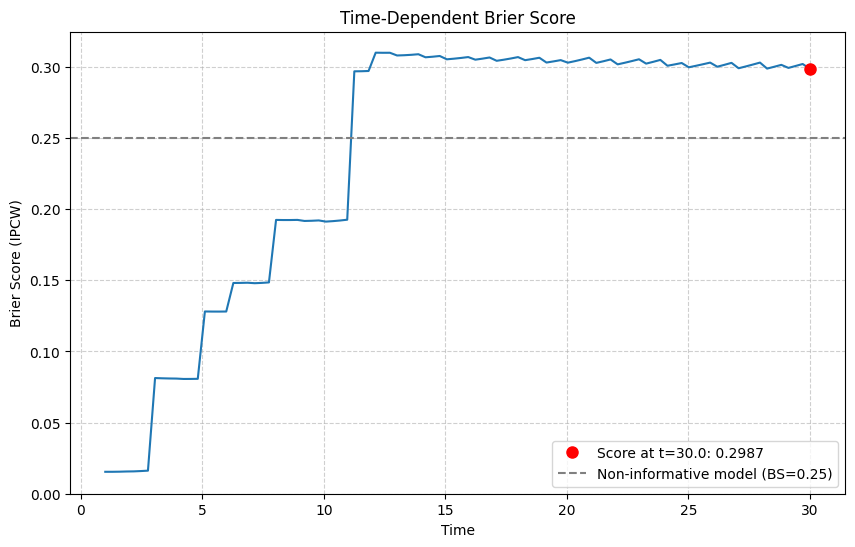

In [113]:
import warnings
from lifelines.exceptions import ApproximationWarning

# Define the time point you want to evaluate
time_to_evaluate = 30 #<--- IMPORTANT: Adjust this time to a relevant value for your data

print(f"Evaluating Brier Score up to t={time_to_evaluate}...")

# Execute the function
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ApproximationWarning)

    evaluate_brier_score(
        cph,
        df_cox,
        duration_col,
        event_col,
        target_time=time_to_evaluate
    )

---

<br>

**4. Model Selection Criteria**

Used to compare the relative quality of different nested models by balancing goodness-of-fit against model complexity.

* **Partial AIC & BIC (Information Criteria)**

  Since the Cox model is semi-parametric, the full likelihood is not specified. Therefore, the traditional AIC and BIC metrics are not defined. Instead, we use their partial counterparts.

  The `lifelines` library provides the partial AIC via the `.AIC_partial_` attribute. The partial BIC, however, must be computed manually using the number of parameters and the sample size.

  * **Interpreting the Output**

    <dd>

    * **Partial AIC**:  
      Based on the partial likelihood, it balances model fit and complexity. Lower values indicate a better trade-off between goodness-of-fit and parsimony.

    * **Partial BIC**:  
      Also derived from the partial likelihood, but applies a stronger penalty for model complexity, especially as sample size increases.

    * **When to Use**:  
      These criteria are most useful when comparing multiple Cox models fitted to the same dataset. They are not absolute indicators of fit.

    * **Important Note**:  
      These metrics are not comparable across different survival model types (e.g., Cox vs Parametric Weibull) because they do not use the same likelihood definition.

    </dd>

In [114]:
import numpy as np

def display_model_fit_metrics(cph_model, dataframe):
    """
    Calculates and displays the partial AIC and BIC for a Cox model.

    Args:
        cph_model: The trained Cox Proportional Hazards model object.
        dataframe: The DataFrame used to fit the model.
    """
    # Display partial AIC (available directly)
    print(f"Partial AIC: {cph_model.AIC_partial_:.2f}")

    # Manually compute partial BIC
    n = dataframe.shape[0]        # Number of observations
    k = len(cph_model.params_)    # Number of fitted parameters
    log_partial_likelihood = cph_model.log_likelihood_
    bic_partial = -2 * log_partial_likelihood + k * np.log(n)

    print(f"Partial BIC: {bic_partial:.2f}")

In [115]:
# Execute the function
display_model_fit_metrics(cph, df_cox)

Partial AIC: 36521.22
Partial BIC: 36622.65


---

<br>

**5. Internal Validation Techniques**

  Internal validation assesses model reliability and corrects for optimism bias by using resampling techniques on the original dataset.

  * **Bootstrapping**: Involves repeated resampling with replacement from the original data to obtain bias-corrected estimates for performance metrics (e.g., C-index).

  * **Cross-Validation**: Partitions the dataset into K folds, then iteratively trains on K-1 folds and tests on the remaining one to produce a more stable performance estimate.

  * **Split-Sample Validation**: The simplest method, which divides the data once into a training and a test subset. It is generally less efficient, especially with smaller sample sizes.

---

<br>

**6. External Validation**

  External validation is the most rigorous test of a model, evaluating its performance on a completely independent dataset (e.g., from another hospital or time period) to assess its real-world generalizability.

  * **Performance Assessment**: Key metrics like the C-index (discrimination) and calibration plots are re-computed on the new data to check if the model's performance holds up.

  * **Transportability**: This assesses whether the learned effects of the predictors (the model's coefficients) are still valid and meaningful in the new population.

  Successful external validation provides the strongest evidence that a model is ready for practical application.


---

<br>

### **References**

<dd>

If you wish to further explore the Cox Proportional Hazards model—its assumptions, estimation methods, applications in medical research, and extensions—there are several foundational and practical works that provide in-depth explanations. Below are some of the most recommended references for both theoretical and applied studies of the method:

* **Cox, D. R. (1972). Regression models and life-tables**. Journal of the Royal Statistical Society: Series B (Methodological), 34(2), 187–220. DOI: 10.1111/j.2517-6161.1972.tb00899.x
 * This seminal paper introduced the proportional hazards model, laying the theoretical foundation for what became the Cox regression model. It remains the cornerstone reference for understanding hazard functions and survival regression.

* **Hosmer, D. W., Lemeshow, S., & May, S. (2008). Applied Survival Analysis: Regression Modeling of Time-to-Event Data** (2nd ed.). Wiley-Interscience. DOI: 10.1002/0471754994
 * A widely used reference for practical application of Cox models in healthcare and clinical research. Includes extensive examples using statistical software such as SAS and SPSS.

* **Therneau, T. M., & Grambsch, P. M. (2000). Modelling Survival Data: Extending the Cox Model. Springer**. DOI: 10.1007/978-1-4757-3294-8
 * This book is considered essential for understanding extensions of the Cox model, including time-varying covariates and stratified models. Written by the developer of the *survival* package in R. Additionally, it is also a fundamental book on the Cox covering key assumptions (proportional hazards, independence, non-informative censoring).

* **Collett, D. (2023). Modelling Survival Data in Medical Research** (4th ed.). Chapman and Hall/CRC. DOI: 10.1201/9781003282525
 * Covers both the Kaplan-Meier and Cox models with clarity and depth, using real-life medical examples and datasets. Suitable for graduate students and professionals.

* **Kleinbaum, D. G., & Klein, M. (2012). Survival Analysis: A Self-Learning Text** (3rd ed.). Springer. DOI: 10.1007/978-1-4419-6646-9
 * A reader-friendly introduction to survival models including Cox regression. Features intuitive explanations and worked examples using software like R and Stata.

* **Tibshirani, R. (1997). The Lasso Method for Variable Selection in the Cox Model.** Statistics in Medicine.
  * Introduces the LASSO method for automatic variable selection in Cox regression by penalizing less important coefficients.

* **Peduzzi, P., Concato, J., Kemper, E., Holford, T. R., & Feinstein, A. R. (1995). A Simulation Study of the Number of Events per Variable in Logistic Regression Analysis.** Journal of Clinical Epidemiology.
  * Classic study that established the practical rule of 10 events per variable (EPV) to ensure estimate stability.

* **Vittinghoff, E., & McCulloch, C. E. (2007). Relaxing the Rule of Ten Events per Variable in Logistic and Cox Regression.** American Journal of Epidemiology, 165(6), 710–718. DOI: 10.1093/aje/kwk052

 * This study uses simulation methods to show that Cox regression models with as few as 5–9 events per variable (EPV) can produce reliable estimates, especially when effects are strong or model complexity is controlled with techniques like regularization or bootstrapping.

* **Harrell, F. E. Jr. (2015). Regression Modeling Strategies.**
  * Covers variable selection, handling multicollinearity, use of splines for nonlinear effects, and strategies to deal with censoring.

* **Steyerberg, E. W. (2019). Clinical Prediction Models: A Practical Approach to Development, Validation, and Updating** (2nd ed.). Springer. DOI: 10.1007/978-3-030-16399-0  
 * Comprehensive guide to model development and validation, including internal and external validation techniques, calibration methods such as calibration belts, and performance metrics like the C-index and Brier score. Widely used in clinical research and survival modeling.

* **Gönen, M., & Heller, G. (2005). Concordance probability and discriminatory power in proportional hazards regression.** *Biometrika*, 92(4), 965–970. DOI: 10.1093/biomet/92.4.965  
 * Foundational paper on the mathematical definition and interpretation of the concordance index (C-index) in proportional hazards models. Provides a solid theoretical basis for discrimination assessment in survival analysis.

* **Royston, P., & Altman, D. G. (2010). Visualizing and assessing discrimination in the logistic regression model using the C-statistic.** *Statistics in Medicine*, 29(24), 2506–2516. DOI: 10.1002/sim.3994  
 * Discusses visualization and interpretation of the C-statistic, offering insights into model discrimination. While focused on logistic models, its principles are often applied to C-index interpretation in survival analysis.

* **Heagerty, P. J., & Zheng, Y. (2005). Survival model predictive accuracy and ROC curves.** *Biometrics*, 61(1), 92–105. DOI: 10.1111/j.0006-341X.2005.030814.x  
 * Introduces the concept of time-dependent ROC curves and AUC for censored survival data. Offers formal methods to evaluate predictive accuracy of Cox models at specific time points. A key reference for dynamic discrimination measures in survival analysis.



<dt>

<br>


---
